In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv("main_df_new.csv")
cols = data.columns

In [4]:
data_main = data[cols[:3]]
data_main.head(3)

,Year,Month,mean
0,1993,1,-11.404970
1,1993,2,-11.400982
2,1993,3,-11.532623


In [5]:
data = data_main.copy()

data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

data.set_index('Date', inplace=True)

In [6]:
data_new = pd.DataFrame({'Date': data.index, 'mean': data['mean']})

data_new = data_new[data_new['mean'] >= -50]

data_new.head(5)

,Date,mean
Date,,
1993-01-01,1993-01-01,-11.404970
1993-02-01,1993-02-01,-11.400982
1993-03-01,1993-03-01,-11.532623
1993-04-01,1993-04-01,-11.357281
1993-05-01,1993-05-01,-10.870235


In [7]:
time_series = data_new['mean']

scaler = MinMaxScaler(feature_range=(0, 1))

time_series_scaled = scaler.fit_transform(time_series.values.reshape(-1, 1))
time_series_scaled = pd.Series(time_series_scaled.flatten(), index=time_series.index)

train_size = int(len(time_series_scaled) * 0.8)
validation_size = int(len(time_series_scaled) * 0.9)

train = time_series_scaled[:train_size]
validation = time_series_scaled[train_size:validation_size]
test = time_series_scaled[validation_size:]



In [22]:
model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 2, 1, 12))
model_fit = model.fit(disp=False)


/anaconda/envs/jupyter_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/anaconda/envs/jupyter_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [23]:
predictions_scaled_train = predictions = model_fit.forecast(steps=len(validation))


/anaconda/envs/jupyter_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/anaconda/envs/jupyter_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [24]:
predictions_scaled_train.head(3)

265    0.748177
266    0.759077
267    0.808574
Name: predicted_mean, dtype: float64

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(validation, predictions_scaled_train)
mape

0.06722219689404697

In [26]:
predictions_test = model_fit.forecast(steps=len(test))


/anaconda/envs/jupyter_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/anaconda/envs/jupyter_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [28]:
mape_test = mean_absolute_percentage_error(test, predictions_test)

Mean Absolute Percentage Error (MAPE) is: 0.11468829419754908


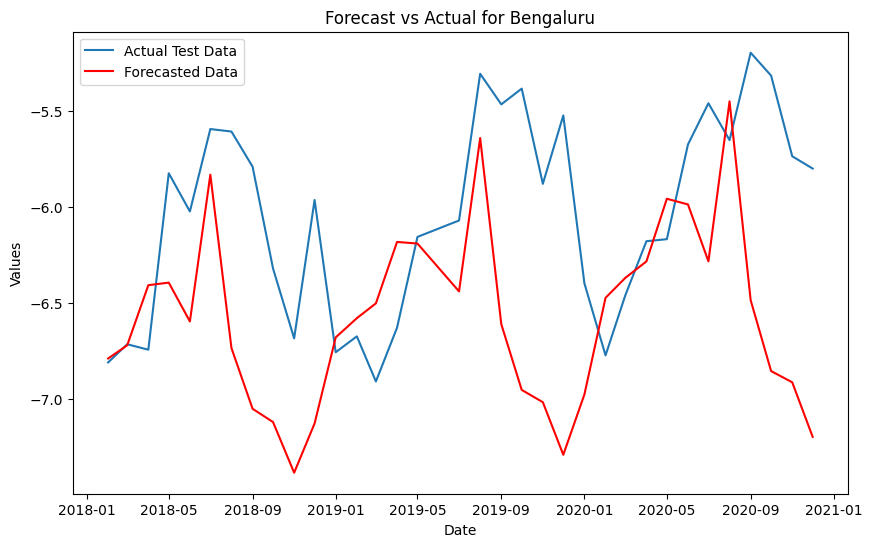

In [32]:
import matplotlib.pyplot as plt

print(f'Mean Absolute Percentage Error (MAPE) is: {mape_test}')

test_actual = scaler.inverse_transform(test.values.reshape(-1, 1))

test_actual_predictions = scaler.inverse_transform(predictions_test.values.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(test.index, test_actual, label='Actual Test Data')
plt.plot(test.index, test_actual_predictions, label='Forecasted Data', color='red')


plt.title('Forecast vs Actual for Bengaluru')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.show()
